# Исследование сервиса аренды самокатов GoFast

В нашем распоряжении данные о некоторых пользователях самокатов GoFast из нескольких городов, а также об их поездках. 
Даны 3 таблицы с  информация о пользователях, их поездках и подписках. 

**Цель проекта** проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти, а главное являются ли пользователи с подпиской более выгодными для компании.

**План работы:**

1. Проведем предобработку данных
2. Проведем исследовательский анализ данных
3. Объединим данные в общую таблицу и выделим группы пользователей с подпиской и без подписки в отдельные таблицы для анализа
4. Создадим датафрейм с агрегированными данными о поездках на основе объединенной таблицы и данных по подписке: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.
5. Оценим являются ли пользователи с подпиской более выгодными для компании, для этого проверим предварительно: тратят ли пользователи с подпиской больше времени на поездки; будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки; а также проверим среднее расстояние, которое проезжают пользователи с подпиской за одну поездку.

Сделаем выводы.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats as st

#### Шаг 1. Загрузка данных

In [2]:
users = pd.read_csv('users_go.csv')
rides = pd.read_csv('rides_go.csv')
subscriptions = pd.read_csv('subscriptions_go.csv')

Выведем первые строки каждого набора данных. Изучим общую информацию о каждом датафрейме.

In [48]:
users.sample(5)

,user_id,name,age,city,subscription_type
722,723,Роберт,24,Ростов-на-Дону,free
298,299,Агата,19,Омск,ultra
1075,1076,Софья,22,Екатеринбург,free
1285,1286,Кира,21,Москва,free
77,78,Ростислав,21,Пятигорск,ultra


In [4]:
users.describe()

,user_id,age
count,1565.000000,1565.000000
mean,762.633866,24.922045
std,443.260155,4.553496
min,1.000000,12.000000
25%,378.000000,22.000000
50%,762.000000,25.000000
75%,1146.000000,28.000000
max,1534.000000,43.000000


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [49]:
rides.sample(5)

,user_id,distance,duration,date,month
5379,576,3333.665862,13.408146,2021-11-05,11
5156,554,987.806496,10.279553,2021-12-07,12
12598,1147,2894.506241,26.788216,2021-06-20,6
5304,570,2598.534410,15.992672,2021-05-22,5
4423,476,2997.686906,22.990748,2021-04-02,4


In [50]:
rides.describe()

,user_id,distance,duration,date,month
count,18068.000000,18068.000000,18068.000000,18068,18068.000000
mean,842.869936,3070.659976,17.805011,2021-06-30 19:47:21.266327296,6.486772
min,1.000000,0.855683,0.500000,2021-01-01 00:00:00,1.000000
25%,487.000000,2543.226360,13.597563,2021-04-02 00:00:00,4.000000
50%,889.000000,3133.609994,17.678395,2021-06-30 00:00:00,6.000000
75%,1213.250000,3776.222735,21.724800,2021-09-28 00:00:00,9.000000
max,1534.000000,7211.007745,40.823963,2021-12-30 00:00:00,12.000000
std,434.734317,1116.831209,6.091051,NaN,3.437410


In [51]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1)
memory usage: 635.3 KB


In [52]:
subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [10]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


**ВЫВОД** Пропущенных значений в датафреймах нет. Но видимо есть дубликаты, поскольку в таблице с пользователями 1565 строк, при этом максимальное значение ID 1534. Кроме того, надо отформатировать дату и привести ее в формат pandas.

Проведем предобработку данных. Приведем столбец 'date' к типу даты pandas, а также проверим и избавимся от дубликатов.

#### Шаг 2. Предобработка данных

Приведем столбец 'date' к типу даты pandas.

In [ ]:
rides['date'] = pd.to_datetime(rides['date'], format = '%Y-%m-%d')
rides['date']

0       2021-01-01
1       2021-01-18
2       2021-04-20
3       2021-08-11
4       2021-08-28
           ...    
18063   2021-11-04
18064   2021-11-16
18065   2021-11-18
18066   2021-11-27
18067   2021-12-29
Name: date, Length: 18068, dtype: datetime64[ns]

In [12]:
rides['month'] = rides['date'].dt.month
rides['month'] 

0         1
1         1
2         4
3         8
4         8
         ..
18063    11
18064    11
18065    11
18066    11
18067    12
Name: month, Length: 18068, dtype: int32

Проверим наличие дубликатов в датафреймах.

In [13]:
users.duplicated().sum()

31

In [14]:
rides.duplicated().sum()

0

Избавимся от дубликатов первом датафрейме.

In [15]:
users = users.drop_duplicates().reset_index(drop=True)

**ВЫВОД** Привели столбец date к типу даты pandas. Создали новый столбец с номером месяца для удобства анализа в дальнейшем. Избавились от дубликатов, теперь количество строк соответствует количеству ID. 

Теперь приступим к исследовательскому анализу данных.

#### Шаг 3. Исследовательский анализ данных

Опишим и визуализируем общую информацию о пользователях и поездках:

##### Частота встречаемости городов

In [17]:
city_proportion = users['city'].value_counts().sort_values(ascending=False)
city_proportion 

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

In [18]:
users['city'].value_counts().mean()

191.75

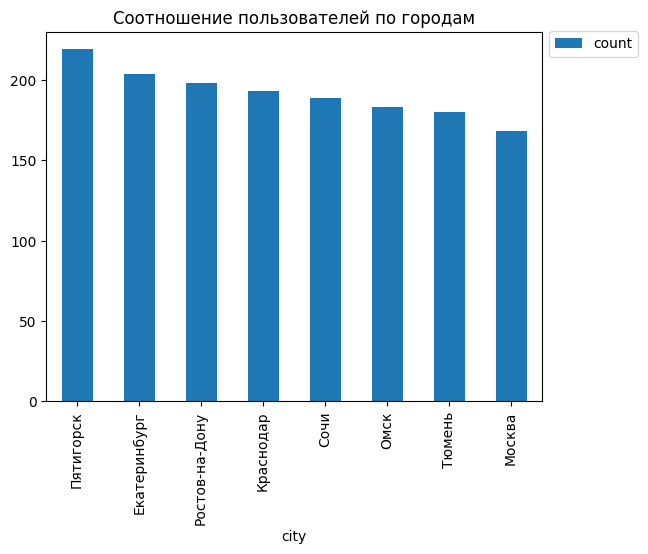

In [19]:
ax = city_proportion.plot(kind="bar",  legend=True, title='Соотношение пользователей по городам', ylabel='')
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

Всего 8 гоородов. Соотношение пользователей близкое, в среднем 191 человек в каждой локации. Больше всего пользователей в Пятигорске, минимум в Москве.

##### Cоотношение пользователей с подпиской и без подписки

In [20]:
users_proportion = users['subscription_type'].value_counts()
users_proportion

subscription_type
free     835
ultra    699
Name: count, dtype: int64

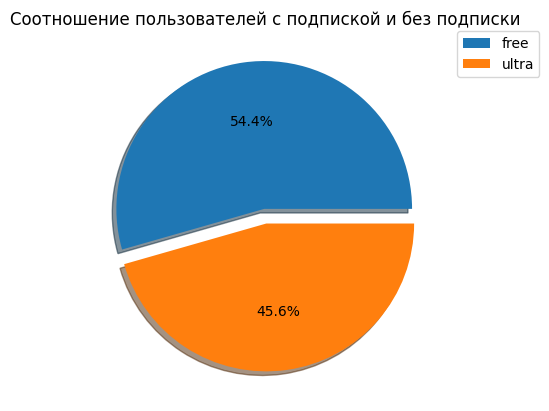

In [21]:
ax = users_proportion .plot(kind="pie", autopct='%1.1f%%', shadow=True, explode=[0.05, 0.05], legend=True, title='Соотношение пользователей с подпиской и без подписки', ylabel='', labeldistance=None)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

In [22]:
users['subscription_type'].count()

1534

Пользователей с подпиской ultra меньше, чем без подпики free, но не значительно . 

##### Возраст пользователей

In [53]:
users_age = users['age'].value_counts()

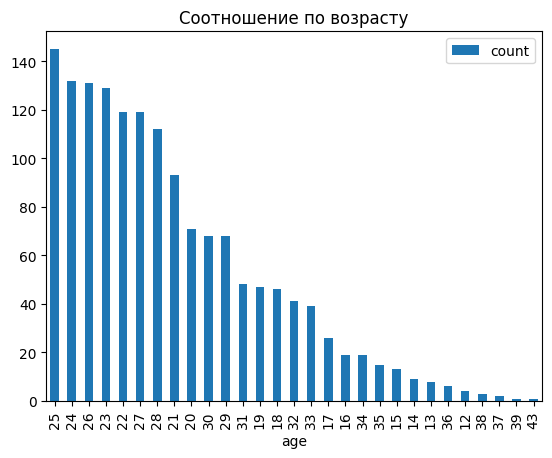

In [54]:
ax = users_age.plot(kind="bar", legend=True, title='Соотношение по возрасту', ylabel='')
plt.show()

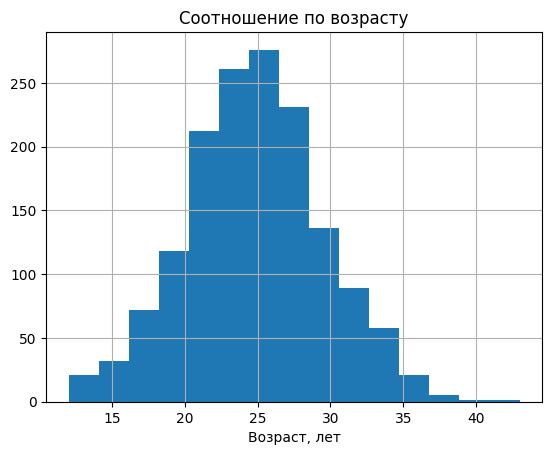

In [25]:
ax = users.hist(column="age", bins = 15)
plt.title("Соотношение по возрасту")
plt.xlabel("Возраст, лет")
plt.show()

Наибольшее количесвто пользователей в возрасте 22-28 лет.

#####  Расстояние, которое пользователь преодолел за одну поездку

In [26]:
ride_distance = rides.pivot_table(index='user_id', values = 'distance', aggfunc= ['sum', 'count','mean']) 
ride_distance.columns = ['sum', 'count','mean']
ride_distance.sort_values('mean', ascending=False)

,sum,count,mean
user_id,,,
1309,34300.155096,8,4287.519387
850,48058.056445,12,4004.838037
644,11819.319983,3,3939.773328
465,35258.034507,9,3917.559390
381,31240.301204,8,3905.037651
...,...,...,...
883,18850.270833,9,2094.474537
1011,26856.956335,13,2065.919718
1433,19912.454930,10,1991.245493


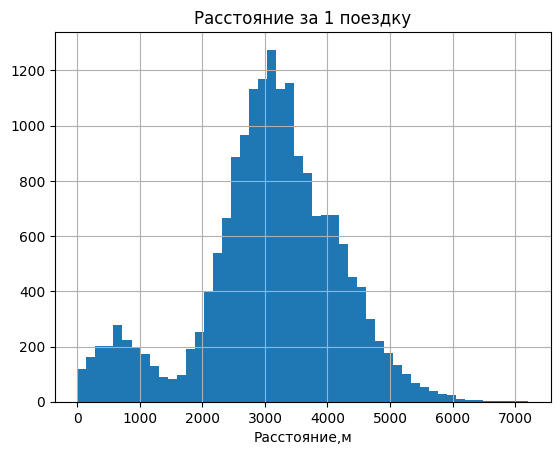

In [27]:
rides['distance'].hist(bins=50)
plt.title("Расстояние за 1 поездку")
plt.xlabel("Расстояние,м")
plt.show()

Рассмотрим пики, применив range

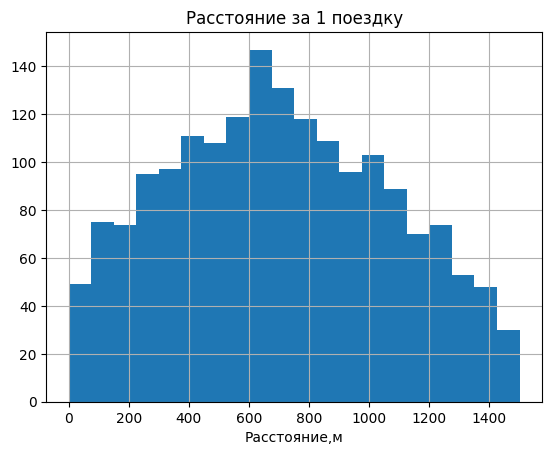

In [28]:
rides['distance'].hist(bins=20, range = (0, 1500))
plt.title("Расстояние за 1 поездку")
plt.xlabel("Расстояние,м")
plt.show()

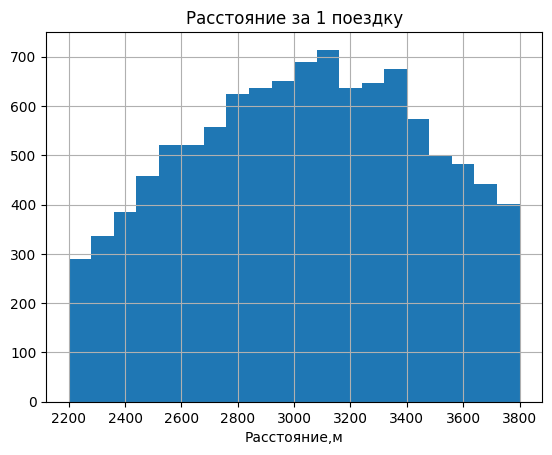

In [29]:
rides['distance'].hist(bins=20, range = (2200, 3800))
plt.title("Расстояние за 1 поездку")
plt.xlabel("Расстояние,м")
plt.show()

In [30]:
rides['distance'].mean().round()

3071.0

В среднем за одну поездку пользователи преодолевают 3 км. Максимальные расстояния преодолевает пользователь с ID=1309 - в среднем 4287 м за 1 поездку, минимальные пользователь с ID=908 - 1630 м за 1 поездку. 

На гистограмее видно 2 пика. Первый - короткие дистанции в диапазоне 600-750 м, а второй длинные поездки в пределах 2,8 км - 3,4 км.

##### Продолжительность поездок

In [31]:
ride_duration = rides.pivot_table(index='user_id', values = 'duration', aggfunc= ['sum', 'count', 'mean']) 
ride_duration.columns = ['sum', 'count','mean']
ride_duration.sort_values('mean', ascending=False)

,sum,count,mean
user_id,,,
657,130.680002,5,26.136000
643,103.358486,4,25.839621
354,76.985937,3,25.661979
522,152.265464,6,25.377577
126,126.821853,5,25.364371
...,...,...,...
801,102.856168,8,12.857021
1256,115.367027,9,12.818559
1243,109.072005,9,12.119112


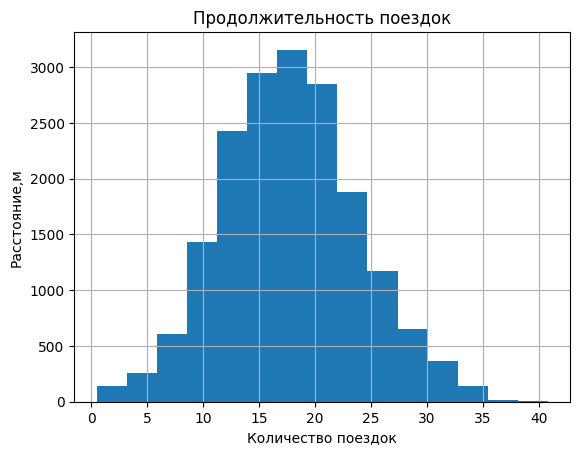

In [32]:
rides['duration'].hist(bins=15)
plt.title("Продолжительность поездок")
plt.xlabel("Количество поездок")
plt.ylabel("Расстояние,м")
plt.show()

In [33]:
rides['duration'].mean().round()

18.0

В среднем поездка длится 18 мин. Чаще всего поездка продолжается 14-22 мин.

**ВЫВОД** В выборке предствалено 8 городов со среднем числом польхоыателей 191 человек. Пользователей с подпиской ultra меньше (45,5%), чем без подпики free (55,5%), но не значительно. Выявили, что в среднем одна поездка длится 18 минут и пользователи преодолевают примерно 3 км.

#### Шаг 4. Объединение данных

Создадим общую таблицу general_table

In [34]:
general_table = users.merge(rides, on='user_id', how='right')
general_table.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8


In [35]:
general_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2), object(3)
memory usage: 1.2+ MB


Теперь из gereral_table создадим 2 таблицы для пользователей с подпиской и без подписки

In [36]:
ultra = general_table[general_table['subscription_type'] == 'ultra']
ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8


In [37]:
free = general_table[general_table['subscription_type'] == 'free']
free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2


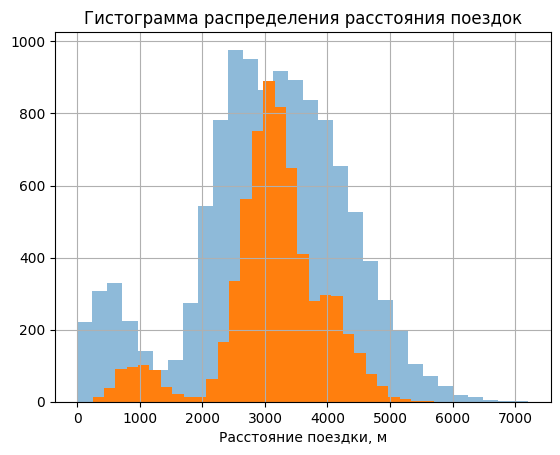

In [38]:
free['distance'].hist(bins = 30, alpha=0.5)
ultra['distance'].hist(bins = 30)
plt.xlabel('Расстояние поездки, м')
plt.title('Гистограмма распределения расстояния поездок')
plt.show()

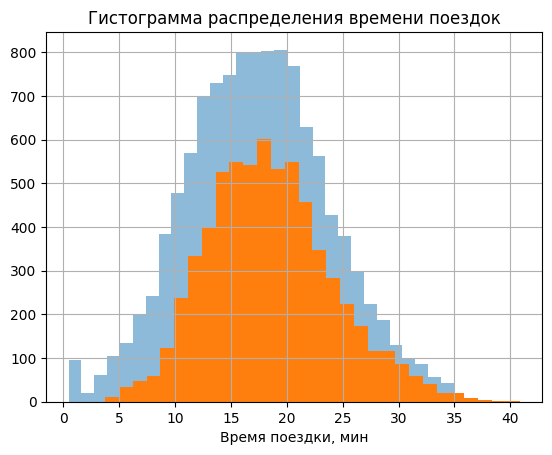

In [39]:
free['duration'].hist(bins = 30, alpha=0.5)
ultra['duration'].hist(bins = 30)
plt.xlabel('Время поездки, мин')
plt.title('Гистограмма распределения времени поездок')
plt.show()

По расстоянию и времени превосходят количество поездок без подписки. 

**ВЫВОД** На этом этапе объединили все данные в одну таблицу и выделели отдельно пользователей с подпиской и без подписки. В результате анализа данных выявили, что пользователи без подписки чаще ездят на короткие расстояния, на длинные растояния пользователи ездят сопоставимо одинаково. Есть всплеск по очень коротким поездкам без подписки - видимо пробные с целью знакомства с сервисом. Поездок без подписки больше, но в целом распределение поездок по времнни можно определить как нормальное.

#### Шаг 5. Подсчёт выручки

Создадим датафрейм с агрегированными данными о поездках на основе general_table и subscription: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [40]:
general_table_sub = general_table.merge(subscriptions, on='subscription_type', how='right')
general_table_sub['duration'] = np.ceil(general_table_sub['duration']) 
general_pivot_table = general_table_sub.pivot_table(index=['user_id', 'month'], aggfunc={
    'distance':'sum',
    'duration':['sum', 'count'],
    'subscription_type':'first', 
    'minute_price':'first', 
    'start_ride_price':'first',
    'subscription_fee':'first'
})
general_pivot_table.columns = [
    'total_distance', 
    'num_of_rides', 
    'total_duration', 
    'minute_price', 
    'start_ride_price', 
    'subscription_fee', 
    'subscription_type'
]

general_pivot_table.head(20)

total_distance  num_of_rides  total_duration  minute_price  \
user_id month                                                               
1       1         7027.511294             2            42.0             6   
        4          754.159807             1             7.0             6   
        8         6723.470560             2            46.0             6   
        10        5809.911100             2            32.0             6   
        11        7003.499363             3            56.0             6   
        12        6751.629942             2            28.0             6   
2       3        10187.723006             3            63.0             6   
        4         6164.381824             2            40.0             6   
        6         3255.338202             1            14.0             6   
        7         6780.722964             2            48.0             6   
        8          923.007439             1             7.0             6   
        10        2824.636598             1            19.0             6   
        12        3828.248580             1            12.0             6   
3       1         3061.777147             1            13.0             6   
        2         5421.152016             2            39.0             6   
        4         2956.651632             1            21.0             6   
        5         9064.026918             3            63.0             6   
        7        10919.595403             3            67.0             6   
        9         2891.012822             1            23.0             6   
        12        2593.381928             1            13.0             6   

               start_ride_price  subscription_fee subscription_type  
user_id month                                                        
1       1                     0               199             ultra  
        4                     0               199             ultra  
        8                     0               199             ultra  
        10                    0               199             ultra  
        11                    0               199             ultra  
        12                    0               199             ultra  
2       3                     0               199             ultra  
        4                     0               199             ultra  
        6                     0               199             ultra  
        7                     0               199             ultra  
        8                     0               199             ultra  
        10                    0               199             ultra  
        12                    0               199             ultra  
3       1                     0               199             ultra  
        2                     0               199             ultra  
        4                     0               199             ultra  
        5                     0               199             ultra  
        7                     0               199             ultra  
        9                     0               199             ultra  
        12                    0               199             ultra

Добавим столбец с помесячной выручкой, которую принёс каждый пользователь

In [41]:
general_pivot_table['revenue'] = general_pivot_table['start_ride_price'] * general_pivot_table['num_of_rides'] \
+ general_pivot_table['minute_price'] * general_pivot_table['total_duration'] + general_pivot_table['subscription_fee']
general_pivot_table['revenue'] #проверка

user_id  month
1        1        451.0
         4        241.0
         8        475.0
         10       391.0
         11       535.0
                  ...  
1534     6        308.0
         8        484.0
         9        234.0
         11       824.0
         12       178.0
Name: revenue, Length: 11331, dtype: float64

#### Шаг 6. Проверка гипотез

##### Тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. 

H0: Нет статистически значимой разницы в продолжительности поездок между пользователями с подпиской и пользователями без подписки.

H1: Пользователи с подпиской тратят значимо больше времени на поездки, чем пользователи без подписки.

In [42]:
alpha = .05
results = st.ttest_ind(ultra['duration'], free['duration'],  alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


In [43]:
ultra['duration'].mean()

18.54198516280583

In [44]:
free['duration'].mean()

17.39090929866399

**ВЫВОД** Пользователи с подпиской тратят больше времени на поездки в среднем на 1 минуту дольше пользователей без подиски.

##### Расстояние одной поездки в  3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

H0: Cреднее расстояние, которое проезжают пользователи с подпиской за одну поездку, близко к значению в 3130 метров.

H1: Пользователи с подпиской проезжают значимо больше 3130 метров.

In [45]:
opt_ride = 3130
alpha = .05
results = st.ttest_1samp(ultra['distance'], opt_ride,  alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


In [46]:
ultra['distance'].mean().round(0)

3115.0

Не получилось отвергнуть нулевую гипотезу, следовательно среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, близко к значению в 3130 метров. В среднем подписчии проезжают 3115 м.

##### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

H0: Помесячная выручка от пользователей с подпиской по месяцам равнв выручке от пользователей без подписки.

H1: Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

In [47]:
ultra_revenue = general_pivot_table.loc[general_pivot_table['subscription_type'] == 'ultra', 'revenue']
free_revenue = general_pivot_table.loc[general_pivot_table['subscription_type'] == 'free', 'revenue']
alpha = .05
results = st.ttest_ind(ultra_revenue, free_revenue,  alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Поскольку нулевая гипотеза отвергнута, далем вывод, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

##### Представим такую ситуацию: тех. команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. 

Поскольку проверяется равенство среднего значения генеральной совокупности до и после изменения, то необходим метод scipy.stats.ttest_rel
Аргументы: наборы данных — парные выборки до и после изменения. 

Гипотеза двусторонаяя, поскольку в результате обновления количествообращений могло как снизится так и вырасти.

#### Шаг 7. Распределения

<b>ВЫВОД</b>

На этапе подготовки данных проведена предобработка данных: проверила датафреймах на наличие пропусков, полных дубликатов и соответствие типов данных. Пропусков и дубликатов нет, исправила тип данных столбца date и добавила новый столбец с номером месяца для удобства анализа в дальнейшем. 
При анализе данных определила, что в выборке представлено 8 городов со среднем числом пользователей 191 человек. 

Пользователей с подпиской ultra меньше (45,5%), чем без подписки free (55,5%), но не значительно. 

<b>Соотношение пользователей с подпиской и без </b>
    
ULTRA  | FREE
------ | ------
45,5%  | 55,5%


Выявили, что в среднем одна поездка длится 18 минут и пользователи преодолевают примерно 3 км.

Сведя все данные в одну таблицы, выявили, что пользователи без подписки чаще используют самокаты для коротких поездок, что объяснимо, на более длительные  поездки пользователи ездят сопоставимо одинаково. 

Поездок без подписки больше, но в целом распределение поездок по времени можно определить как нормальное.

Выявили, что пользователи с подпиской тратят в среднем на 1 минуту больше времени, чем пользователей без подписки. Таким образом пользователи с подпиской не на много выгоднее для компании, чем пользователи без подписки. 

Расстояние одной поездки в  3130 метров — оптимальное с точки зрения износа самоката. При анализе данных рассчитали что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 и составляет в среднем  3115 м. Т.е. поездки подписчиков не причиняют повышенный износ самокатам и, следовательно, не приносят убытки длинными поездками.

Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки - данная гипотеза получила подтверждение.

В целях увеличения прибыли сервису стоит искать пути привлечения пользователей оформлять подписку, поскольку они приносят больше прибыли , используя самокаты на более долгие поездки, но при этом не нанося излишний износ самокатам.